testのラベル数が100以上のラベルについて、ランダムに100個ずつ input.txtとtrue.txtを作る

pip install mmseqs foldseek

In [6]:
import json
import os
import random
from collections import Counter, defaultdict

# JSON ファイルのパス（必要に応じてパスを調整してください）
json_path = "dataset/test_split.json"

# 出力ディレクトリの作成（存在しない場合）
os.makedirs("PLG", exist_ok=True)

# JSON ファイルを読み込み
with open(json_path, "r", encoding="utf-8") as f:
    data = json.load(f)

# "[Generate by Substrate]" の例だけを抽出
filtered = [entry for entry in data if entry["instruction"] == "[Generate by Substrate]"]

# filtered[i]['input']の頻度分布を確認
input_counter = Counter([entry['input'] for entry in filtered])
print(input_counter)

# 100回以上出現する入力を抽出
frequent_inputs = [input for input, count in input_counter.items() if count >= 100]
print(frequent_inputs)


# input ごとにエントリをまとめるための辞書
input_to_entries = defaultdict(list)
for entry in filtered:
    input_to_entries[entry['input']].append(entry)

Counter({'Substrate=<potassium(1+)>': 1533, 'Substrate=<sodium(1+)>': 1126, 'Substrate=<Ala-Lys(1+), L-aminoacyl-L-arginine(1+), L-aminoacyl-L-histidine zwitterion, L-aminoacyl-L-lysine(1+), L-arginyl-L-alpha-amino acid(1+), Arg-Gly(1+), Asp-Lys zwitterion,  L-histidyl-L-alpha-amino acid zwitterion, His-Gly zwitterion, Lys-Ala(1+), L-lysyl-L-alpha-amino acid(1+), Lys-Lys(2+), Lys-Gly(1+)>': 927, 'Substrate=<ADP(3-), ATP(4-)>': 427, 'Substrate=<copper(1+)>': 351, 'Substrate=<chloride>': 334, 'Substrate=<zinc(2+), hydron>': 262, 'Substrate=<zinc(2+)>': 231, 'Substrate=<calcium(2+)>': 194, 'Substrate=<sodium(1+), hydrogenphosphate, potassium(1+), hydron, L-glutamate(1-), chloride>': 184, 'Substrate=<calcium(2+), potassium(1+), sodium(1+)>': 168, 'Substrate=<D-aspartate(1-), potassium(1+), sodium(1+), hydron, L-aspartate(1-), L-glutamate(1-)>': 159, 'Substrate=<calcium(2+), manganese(2+)>': 145, 'Substrate=<ADP(3-), ATP(4-), hydron>': 143, 'Substrate=<gamma-aminobutyric acid zwitterion, ch

In [ ]:

# -----------------------------
# 1. PLG/input.txt の作成
# -----------------------------
input_file_path = "PLG/input.txt"
with open(input_file_path, "w", encoding="utf-8") as f_in:
    for inp in frequent_inputs:
        # 各 input について 100 行出力
        for _ in range(100):
            line = f"[Generate by Substrate] {inp}"
            f_in.write(line + "\n")
print(f"'{input_file_path}' を出力しました。")

# -----------------------------
# 2. PLG/true.txt の作成
# -----------------------------
true_file_path = "PLG/true.txt"
with open(true_file_path, "w", encoding="utf-8") as f_true:
    for inp in frequent_inputs:
        entries = input_to_entries[inp]
        # その input に対応するエントリを100個選ぶ
        selected_entries = entries[:100]
        for e in selected_entries:
            line = f'[Generate by Substrate] {e["input"]} {e["output"]}'
            f_true.write(line + "\n")
print(f"'{true_file_path}' を出力しました。")


In [ ]:
import torch
from transformers import LlamaForCausalLM, LlamaTokenizer, GenerationConfig
from tqdm import tqdm
import os

# 生成設定（必要に応じて調整してください）
generation_config = GenerationConfig(
    temperature=0.7,
    top_k=40,
    top_p=0.9,
    do_sample=True,
    num_beams=1,
    repetition_penalty=1.2,
    max_new_tokens=900
)

# GPU チェック
load_type = torch.bfloat16
if torch.cuda.is_available():
    device = torch.device(0)
else:
    raise ValueError("No GPU available.")

# モデルパスの指定
model_path = 'stored_output/checkpoint-2epoch'
model = LlamaForCausalLM.from_pretrained(
    model_path,
    torch_dtype=load_type,
    low_cpu_mem_usage=True,
    device_map='auto',
    quantization_config=None
)
model.eval()
tokenizer = LlamaTokenizer.from_pretrained(model_path)

/home/yosshstd/anaconda3/envs/unsloth_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 2/2 [00:09<00:00,  4.64s/it]


In [3]:
outputs = []
# 入力ファイルと出力ファイルのパス
input_file = "PLG/input.txt"
output_file = "PLG/pred.txt"
# 出力先ディレクトリが存在しない場合は作成
os.makedirs(os.path.dirname(output_file), exist_ok=True)
# 入力ファイルの読み込み
with open(input_file, 'r', encoding='utf-8') as f:
    examples = f.read().splitlines()

# バッチサイズの設定
batch_size = 4
tokenizer.padding_side = 'left'

print("Start generating predictions...")
# バッチ処理の実装
for i in tqdm(range(0, len(examples), batch_size), desc="Processing batches"):
    # 現在のバッチを取得
    batch_examples = examples[i:i + batch_size]
    
    # バッチ内の例をトークナイズ
    batch_inputs = tokenizer(batch_examples, padding=True, truncation=True, return_tensors="pt")
    
    # モデルによる生成
    batch_outputs = model.generate(
        input_ids=batch_inputs["input_ids"].to(device),
        attention_mask=batch_inputs['attention_mask'].to(device),
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.pad_token_id,
        generation_config=generation_config
    )
    
    # 生成結果のデコード
    for j in range(len(batch_examples)):
        output = tokenizer.decode(batch_outputs[j], skip_special_tokens=True)
        output = output.replace("</s>", "")
        outputs.append(output)

Start generating predictions...


Processing batches: 100%|██████████| 475/475 [4:08:22<00:00, 31.37s/it]  


In [5]:
# 予測結果の書き出し
with open(output_file, 'w', encoding='utf-8') as f:
    f.write("\n".join(outputs))

print("All the outputs have been saved in", output_file)

All the outputs have been saved in PLG/pred.txt


/tmp/ipykernel_1402203/335271682.py:67: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(
/tmp/ipykernel_1402203/335271682.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=90)
/tmp/ipykernel_1402203/335271682.py:95: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout() # レイアウトの調整.  特にx軸ラベルが長い場合に重要


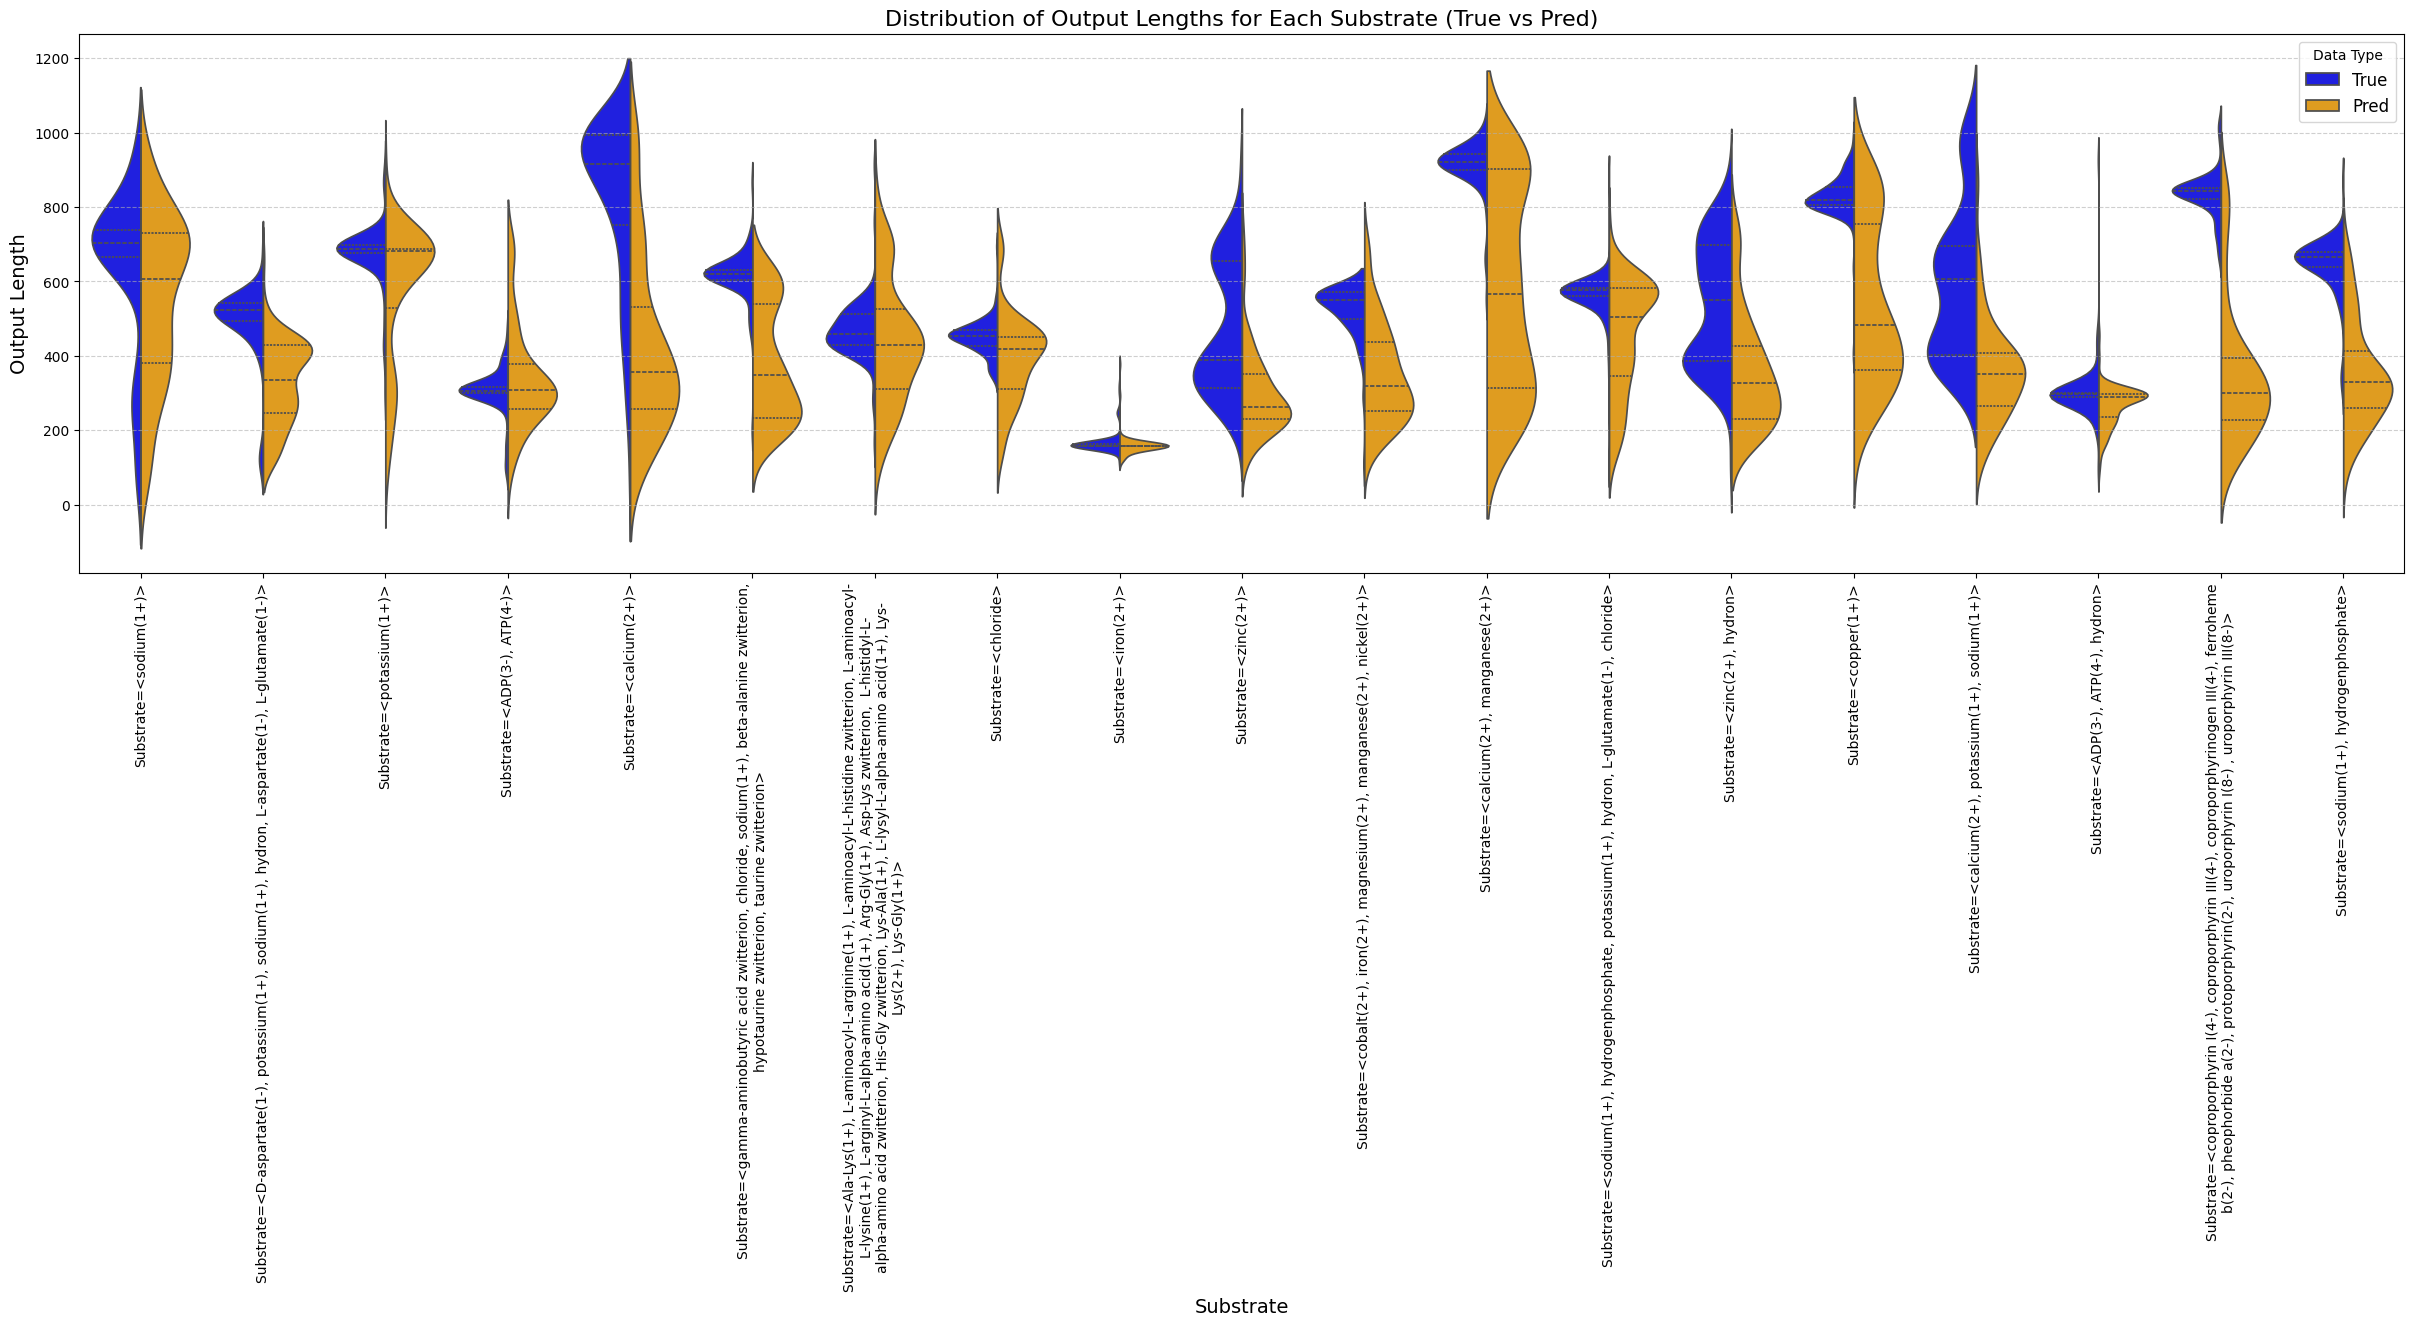

In [12]:
import re
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from textwrap import wrap

def extract_substrate_and_length(line):
    """
    行から最初に現れる "Substrate=<...>" をキーとして抽出し、
    その後に現れる "Seq=<...>" の中身の文字列の長さを返す。
    
    例:
      "[Generate by Substrate] Substrate=<sodium(1+)> Seq=<ABCDEFG>" 
      → ("Substrate=<sodium(1+)>", len("ABCDEFG"))
    """
    # Substrate の抽出
    substrate_match = re.search(r"(Substrate=<.+?>)", line)
    if not substrate_match:
        return None, None
    substrate_key = substrate_match.group(1)
    
    # Seq の中身（角括弧を除く）を抽出
    seq_match = re.search(r"Seq=<(.+?)>", line)
    if seq_match:
        seq_content = seq_match.group(1).strip()
        return substrate_key, len(seq_content)
    else:
        return substrate_key, 0

# ファイルの読み込み
with open("PLG/true.txt", "r", encoding="utf-8") as f_true, open("PLG/pred_temperture0.7.txt", "r", encoding="utf-8") as f_pred:
    true_lines = f_true.read().splitlines()
    pred_lines = f_pred.read().splitlines()


# 各頻出 Substrate ごとの出力長さを記録する辞書（キーは頻出入力、値は長さのリスト）
true_lengths = {substrate: [] for substrate in frequent_inputs}
pred_lengths = {substrate: [] for substrate in frequent_inputs}

# true.txt の解析
for line in true_lines:
    substrate, length = extract_substrate_and_length(line)
    if substrate is not None and substrate in true_lengths:
        true_lengths[substrate].append(length)

# pred.txt の解析
for line in pred_lines:
    substrate, length = extract_substrate_and_length(line)
    if substrate is not None and substrate in pred_lengths:
        pred_lengths[substrate].append(length)

# バイオリンプロット用の DataFrame を作成
data = []
for substrate in frequent_inputs:
    # true のデータ
    for length in true_lengths[substrate]:
        data.append({"Substrate": substrate, "Type": "True", "Length": length})
    # pred のデータ
    for length in pred_lengths[substrate]:
        data.append({"Substrate": substrate, "Type": "Pred", "Length": length})

df = pd.DataFrame(data)

# プロット作成：各 Substrate ごとに、True と Pred を分割バイオリンプロットで表示
fig, ax = plt.subplots(1, 1, figsize=(30, 7))

sns.violinplot(
    x="Substrate",
    y="Length",
    hue="Type",
    data=df,
    split=True,
    inner="quartile",
    scale="width",
    palette={"True": "blue", "Pred": "orange"},
    ax=ax
)
ax.set_title("Distribution of Output Lengths for Each Substrate (True vs Pred)", fontsize=16)

# グリッド線を表示
ax.grid(axis='y', linestyle='--', alpha=0.6)

# 凡例を表示
ax.legend(title="Data Type", fontsize=12)

# 軸ラベルを表示
ax.set_xlabel("Substrate", fontsize=14)
ax.set_ylabel("Output Length", fontsize=14)


# x軸ラベルを複数行に分割
labels = [ '\n'.join(wrap(l, 100)) for l in df['Substrate'].unique() ]  # 20文字で改行
ax.set_xticklabels(labels, rotation=90)

plt.tight_layout() # レイアウトの調整.  特にx軸ラベルが長い場合に重要
plt.show()

In [ ]:
from transformers import AutoTokenizer, EsmForProteinFolding
import torch

tokenizer = AutoTokenizer.from_pretrained("facebook/esmfold_v1")
model = EsmForProteinFolding.from_pretrained("facebook/esmfold_v1", low_cpu_mem_usage=True)

model = model.cuda().eval()

# Uncomment to switch the stem to float16
model.esm = model.esm.half()
# Uncomment this line if your GPU memory is 16GB or less, or if you're folding longer (over 600 or so) sequences
model.trunk.set_chunk_size(64)

test_protein = "MKQYTVTGMSCAACSARVEKAVSKVDGVTACSVSLLTNSMGVEGSASDADIIRAVENAGYGAALRNGEAKKSSDLSETEESLKDTETPKIRNRLIWSIVFLIPLMYISMHHMLKEWFGLPVPDIINHVAHEAIAFAFTQLILCLFILFANRTFFINGIKSLWHGAPNMDTLVALGSMASAYISTFLALAMATGRMELAEQYYHDLYFESTVMILTLITLGKYLEEKSMTTRTASSLNRMIELTPEGASTIVREGREIEIPAEEVVIEDIFVVKPGERLPVDGMITEGETCIEEAMLTGESMPISKTAGDRVISGTINRSGTFKFRATHIGSDTTLSKIIHLVEDAASTKAPIARTADRIASVFVPAVIIIAILTAICWLAAGESFNFALNLMIAVLVISCPCALGLATPVAIMVGTGKGAEYGILIKSGEALETMHSIDTVVLDKTGTITSGHPAVTDVILWNKKNTREEFLAAAAAVEARYSEHPLAECIVEWAKSRGVSPEEPDNFSALLGNGLQAKFDDETYRVGGPRDFSASHKMSEEAGMQTIAFDAGRRLTSNKEYQVKDDVLRNGKTPLMFCENDHFIGIICVADTIKPDSPHAIKELKDMGIEVCMITGDSENTARAIGNKVGITHVIAGVLPDGKEKVVERLKKYGKVAMVGDGINDGPALTRANVGIAIGAGTDVAIDAADVVLMKSRLSDVPAAIRLSRAT"
print(f'Length of the input protein: {len(test_protein)}')
tokenized_input = tokenizer([test_protein], return_tensors="pt", add_special_tokens=False)['input_ids'].cuda()

with torch.no_grad():
    output = model(tokenized_input)


from transformers.models.esm.openfold_utils.protein import to_pdb, Protein as OFProtein
from transformers.models.esm.openfold_utils.feats import atom14_to_atom37

def convert_outputs_to_pdb(outputs):
    final_atom_positions = atom14_to_atom37(outputs["positions"][-1], outputs)
    outputs = {k: v.to("cpu").numpy() for k, v in outputs.items()}
    final_atom_positions = final_atom_positions.cpu().numpy()
    final_atom_mask = outputs["atom37_atom_exists"]
    pdbs = []
    for i in range(outputs["aatype"].shape[0]):
        aa = outputs["aatype"][i]
        pred_pos = final_atom_positions[i]
        mask = final_atom_mask[i]
        resid = outputs["residue_index"][i] + 1
        pred = OFProtein(
            aatype=aa,
            atom_positions=pred_pos,
            atom_mask=mask,
            residue_index=resid,
            b_factors=outputs["plddt"][i],
            chain_index=outputs["chain_index"][i] if "chain_index" in outputs else None,
        )
        pdbs.append(to_pdb(pred))
    return pdbs

pdb = convert_outputs_to_pdb(output)

with open("output_structure.pdb", "w") as f:
    f.write("".join(pdb))

Length of the input protein: 712


In [1]:
import os
import re
from transformers import AutoTokenizer, EsmForProteinFolding
import torch
from transformers.models.esm.openfold_utils.protein import to_pdb, Protein as OFProtein
from transformers.models.esm.openfold_utils.feats import atom14_to_atom37

# substrateに対応する配列をPLG/pred.txtから読み込む関数
def load_sequences(substrate_name, file_path="PLG/pred.txt", num_seqs=100): 
    sequences = []
    # 正規表現パターン：Substrate=<...>とSeq=<...>の内容を抽出
    pattern = re.compile(r"\[Generate by Substrate\]\s+Substrate=<([^>]+)>\s+Seq=<([^>]+)>")
    with open(file_path, "r") as f:
        for line in f:
            match = pattern.search(line)
            if match:
                substrate, seq = match.groups()
                if substrate == substrate_name:
                    sequences.append(seq)
                    if len(sequences) >= num_seqs:
                        break
    if not sequences:
        raise ValueError(f"substrate_name '{substrate_name}' に一致する配列が見つかりませんでした。")
    return sequences

# ESMFoldの出力をPDB形式に変換する関数
def convert_outputs_to_pdb(outputs):
    final_atom_positions = atom14_to_atom37(outputs["positions"][-1], outputs)
    outputs = {k: v.to("cpu").numpy() for k, v in outputs.items()}
    final_atom_positions = final_atom_positions.cpu().numpy()
    final_atom_mask = outputs["atom37_atom_exists"]
    pdbs = []
    for i in range(outputs["aatype"].shape[0]):
        aa = outputs["aatype"][i]
        pred_pos = final_atom_positions[i]
        mask = final_atom_mask[i]
        resid = outputs["residue_index"][i] + 1
        pred = OFProtein(
            aatype=aa,
            atom_positions=pred_pos,
            atom_mask=mask,
            residue_index=resid,
            b_factors=outputs["plddt"][i],
            chain_index=outputs["chain_index"][i] if "chain_index" in outputs else None,
        )
        pdbs.append(to_pdb(pred))
    return pdbs

/home/yosshstd/anaconda3/envs/unsloth_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
substrate_name = "zinc(2+)"

output_dir = os.path.join("PLG", "pred_pdb", f"{substrate_name}_pdb")
os.makedirs(output_dir, exist_ok=True)

# PLG/pred.txtから対象の100配列を抽出
sequences = load_sequences(substrate_name, file_path="PLG/pred.txt", num_seqs=100)
print(f"substrate '{substrate_name}' の配列数: {len(sequences)}")

# モデルの準備
tokenizer = AutoTokenizer.from_pretrained("facebook/esmfold_v1")
model = EsmForProteinFolding.from_pretrained("facebook/esmfold_v1", low_cpu_mem_usage=True)
model = model.cuda().eval()

# GPUメモリに応じてfloat16化・chunk_sizeの設定
model.esm = model.esm.half()
model.trunk.set_chunk_size(64)

# 各配列の構造予測とPDB出力
for idx, protein in enumerate(sequences, start=1):
    print(f"[{idx}/{len(sequences)}] Folding protein with length {len(protein)}")
    tokenized_input = tokenizer([protein], return_tensors="pt", add_special_tokens=False)['input_ids'].cuda()
    with torch.no_grad():
        outputs = model(tokenized_input)
    pdb_list = convert_outputs_to_pdb(outputs)
    # pdb_listには入力数分（ここでは1）の構造が入っているので先頭を利用
    pdb_content = pdb_list[0]
    # ファイル名例: pred_001.pdb, pred_002.pdb, ...
    pdb_file = os.path.join(output_dir, f"pred_{idx:03d}.pdb")
    with open(pdb_file, "w") as f:
        f.write(pdb_content)
    print(f"  -> Saved: {pdb_file}")

substrate 'zinc(2+)' の配列数: 100


Some weights of EsmForProteinFolding were not initialized from the model checkpoint at facebook/esmfold_v1 and are newly initialized: ['esm.contact_head.regression.bias', 'esm.contact_head.regression.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[1/100] Folding protein with length 218
  -> Saved: PLG/pred_pdb/zinc(2+)_pdb/pred_001.pdb
[2/100] Folding protein with length 364
  -> Saved: PLG/pred_pdb/zinc(2+)_pdb/pred_002.pdb
[3/100] Folding protein with length 279
  -> Saved: PLG/pred_pdb/zinc(2+)_pdb/pred_003.pdb
[4/100] Folding protein with length 291
  -> Saved: PLG/pred_pdb/zinc(2+)_pdb/pred_004.pdb
[5/100] Folding protein with length 234
  -> Saved: PLG/pred_pdb/zinc(2+)_pdb/pred_005.pdb
[6/100] Folding protein with length 230
  -> Saved: PLG/pred_pdb/zinc(2+)_pdb/pred_006.pdb
[7/100] Folding protein with length 244
  -> Saved: PLG/pred_pdb/zinc(2+)_pdb/pred_007.pdb
[8/100] Folding protein with length 378
  -> Saved: PLG/pred_pdb/zinc(2+)_pdb/pred_008.pdb
[9/100] Folding protein with length 469
  -> Saved: PLG/pred_pdb/zinc(2+)_pdb/pred_009.pdb
[10/100] Folding protein with length 143
  -> Saved: PLG/pred_pdb/zinc(2+)_pdb/pred_010.pdb
[11/100] Folding protein with length 181
  -> Saved: PLG/pred_pdb/zinc(2+)_pdb/pred_011.p

In [10]:
substrate_name = "zinc(2+)"

output_dir = os.path.join("PLG", "true_pdb", f"{substrate_name}_pdb")
os.makedirs(output_dir, exist_ok=True)

# PLG/pred.txtから対象の100配列を抽出
sequences = load_sequences(substrate_name, file_path="PLG/true.txt", num_seqs=100)
print(f"substrate '{substrate_name}' の配列数: {len(sequences)}")

# モデルの準備
tokenizer = AutoTokenizer.from_pretrained("facebook/esmfold_v1")
model = EsmForProteinFolding.from_pretrained("facebook/esmfold_v1", low_cpu_mem_usage=True)
model = model.cuda().eval()

# GPUメモリに応じてfloat16化・chunk_sizeの設定
model.esm = model.esm.half()
model.trunk.set_chunk_size(64)

# 各配列の構造予測とPDB出力
for idx, protein in enumerate(sequences, start=1):
    print(f"[{idx}/{len(sequences)}] Folding protein with length {len(protein)}")
    tokenized_input = tokenizer([protein], return_tensors="pt", add_special_tokens=False)['input_ids'].cuda()
    with torch.no_grad():
        outputs = model(tokenized_input)
    pdb_list = convert_outputs_to_pdb(outputs)
    # pdb_listには入力数分（ここでは1）の構造が入っているので先頭を利用
    pdb_content = pdb_list[0]
    # ファイル名例: pred_001.pdb, pred_002.pdb, ...
    pdb_file = os.path.join(output_dir, f"true_{idx:03d}.pdb")
    with open(pdb_file, "w") as f:
        f.write(pdb_content)
    print(f"  -> Saved: {pdb_file}")

substrate 'zinc(2+)' の配列数: 100


Some weights of EsmForProteinFolding were not initialized from the model checkpoint at facebook/esmfold_v1 and are newly initialized: ['esm.contact_head.regression.bias', 'esm.contact_head.regression.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[1/100] Folding protein with length 469
  -> Saved: PLG/true_pdb/zinc(2+)_pdb/true_001.pdb
[2/100] Folding protein with length 201
  -> Saved: PLG/true_pdb/zinc(2+)_pdb/true_002.pdb
[3/100] Folding protein with length 833
  -> Saved: PLG/true_pdb/zinc(2+)_pdb/true_003.pdb
[4/100] Folding protein with length 427
  -> Saved: PLG/true_pdb/zinc(2+)_pdb/true_004.pdb
[5/100] Folding protein with length 741
  -> Saved: PLG/true_pdb/zinc(2+)_pdb/true_005.pdb
[6/100] Folding protein with length 359
  -> Saved: PLG/true_pdb/zinc(2+)_pdb/true_006.pdb
[7/100] Folding protein with length 344
  -> Saved: PLG/true_pdb/zinc(2+)_pdb/true_007.pdb
[8/100] Folding protein with length 377
  -> Saved: PLG/true_pdb/zinc(2+)_pdb/true_008.pdb
[9/100] Folding protein with length 390
  -> Saved: PLG/true_pdb/zinc(2+)_pdb/true_009.pdb
[10/100] Folding protein with length 303
  -> Saved: PLG/true_pdb/zinc(2+)_pdb/true_010.pdb
[11/100] Folding protein with length 378
  -> Saved: PLG/true_pdb/zinc(2+)_pdb/true_011.p

In [3]:
from Bio.PDB import PDBParser

def get_average_plddt(pdb_file):
    parser = PDBParser()
    structure = parser.get_structure("protein", pdb_file)
    plddts = []
    for model in structure:
        for chain in model:
            for residue in chain:
                if "CA" in residue:  # CA原子が存在する場合(アミノ酸残基)
                    plddts.append(residue["CA"].get_bfactor()) # B-factorがpLDDT
    return sum(plddts) / len(plddts)

# フォルダ内の全PDBファイルに対してpLDDTの平均値を計算
def calculate_average_plddt_in_folder(folder_path):
    plddt_values = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".pdb"):
            plddt = get_average_plddt(os.path.join(folder_path, file_name))
            plddt_values.append(plddt)
    return plddt_values

# pred_pdbフォルダ内の全PDBファイルに対してpLDDTの平均値を計算
pred_plddt_values = calculate_average_plddt_in_folder("PLG/pred_pdb/zinc(2+)_pdb")
print(f"pred_pdb フォルダ内の全PDBファイルのpLDDT平均値: {sum(pred_plddt_values) / len(pred_plddt_values):.2f}")

# true_pdbフォルダ内の全PDBファイルに対してpLDDTの平均値を計算
true_plddt_values = calculate_average_plddt_in_folder("PLG/true_pdb/zinc(2+)_pdb")
print(f"true_pdb フォルダ内の全PDBファイルのpLDDT平均値: {sum(true_plddt_values) / len(true_plddt_values):.2f}")

/home/yosshstd/anaconda3/envs/unsloth_env/lib/python3.12/site-packages/Bio/PDB/PDBParser.py:384: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2767
  warnings.warn(
/home/yosshstd/anaconda3/envs/unsloth_env/lib/python3.12/site-packages/Bio/PDB/PDBParser.py:384: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2567
  warnings.warn(
/home/yosshstd/anaconda3/envs/unsloth_env/lib/python3.12/site-packages/Bio/PDB/PDBParser.py:384: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1532
  warnings.warn(
/home/yosshstd/anaconda3/envs/unsloth_env/lib/python3.12/site-packages/Bio/PDB/PDBParser.py:384: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2749
  warnings.warn(
/home/yosshstd/anaconda3/envs/unsloth_env/lib/python3.12/site-packages/Bio/PDB/PDBParser.py:384: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1734
  warnings.warn(
/home/yosshstd/anaconda3/envs/unsloth_env/lib/python3.12/site-packages

pred_pdb フォルダ内の全PDBファイルのpLDDT平均値: 0.74


/home/yosshstd/anaconda3/envs/unsloth_env/lib/python3.12/site-packages/Bio/PDB/PDBParser.py:384: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3542
  warnings.warn(
/home/yosshstd/anaconda3/envs/unsloth_env/lib/python3.12/site-packages/Bio/PDB/PDBParser.py:384: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3527
  warnings.warn(
/home/yosshstd/anaconda3/envs/unsloth_env/lib/python3.12/site-packages/Bio/PDB/PDBParser.py:384: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5883
  warnings.warn(
/home/yosshstd/anaconda3/envs/unsloth_env/lib/python3.12/site-packages/Bio/PDB/PDBParser.py:384: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2108
  warnings.warn(
/home/yosshstd/anaconda3/envs/unsloth_env/lib/python3.12/site-packages/Bio/PDB/PDBParser.py:384: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4955
  warnings.warn(
/home/yosshstd/anaconda3/envs/unsloth_env/lib/python3.12/site-packages

true_pdb フォルダ内の全PDBファイルのpLDDT平均値: 0.82


/home/yosshstd/anaconda3/envs/unsloth_env/lib/python3.12/site-packages/Bio/PDB/PDBParser.py:384: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4911
  warnings.warn(
/home/yosshstd/anaconda3/envs/unsloth_env/lib/python3.12/site-packages/Bio/PDB/PDBParser.py:384: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5171
  warnings.warn(
/home/yosshstd/anaconda3/envs/unsloth_env/lib/python3.12/site-packages/Bio/PDB/PDBParser.py:384: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2242
  warnings.warn(
/home/yosshstd/anaconda3/envs/unsloth_env/lib/python3.12/site-packages/Bio/PDB/PDBParser.py:384: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5127
  warnings.warn(
/home/yosshstd/anaconda3/envs/unsloth_env/lib/python3.12/site-packages/Bio/PDB/PDBParser.py:384: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1733
  warnings.warn(
/home/yosshstd/anaconda3/envs/unsloth_env/lib/python3.12/site-packages

In [ ]:
# # Foldseek GPU版をダウンロード
# wget https://mmseqs.com/foldseek/foldseek-linux-gpu.tar.gz

# # 圧縮ファイルを展開
# tar xvfz foldseek-linux-gpu.tar.gz

# # 実行ファイルのパスを通す
# export PATH=$(pwd)/foldseek/bin/:$PATH

# 環境変数の永続化
# echo 'export PATH=$(pwd)/foldseek/bin/:$PATH' >> ~/.bashrc
# source ~/.bashrc

In [15]:
!foldseek createdb 'PLG/pred_pdb/zinc(2+)_pdb' 'PLG/pred_pdb/zinc(2+)_pdb/foldseek_db'

createdb PLG/pred_pdb/zinc(2+)_pdb PLG/pred_pdb/zinc(2+)_pdb/foldseek_db 

MMseqs Version:             	fbf7df0710e901e62e9d140060209eafac81e862
Use GPU                     	0
Path to ProstT5             	
Chain name mode             	0
Createdb extraction mode    	0
Interface distance threshold	8
Write mapping file          	0
Mask b-factor threshold     	0
Coord store mode            	2
Write lookup file           	1
Input format                	0
File Inclusion Regex        	.*
File Exclusion Regex        	^$
Threads                     	36
Verbosity                   	3

Output file: PLG/pred_pdb/zinc(2+)_pdb/foldseek_db
[=================================================================] 100.00% 100 0s 85ms    
Time for merging to foldseek_db_ss: 0h 0m 0s 20ms
Time for merging to foldseek_db_h: 0h 0m 0s 1ms
Time for merging to foldseek_db_ca: 0h 0m 0s 1ms
Time for merging to foldseek_db: 0h 0m 0s 1ms
Ignore 0 out of 100.
Too short: 0, incorrect: 0, not proteins: 0.
Time for process

In [18]:
!foldseek createdb 'PLG/true_pdb/zinc(2+)_pdb' 'PLG/true_pdb/zinc(2+)_pdb/foldseek_db'

createdb PLG/true_pdb/zinc(2+)_pdb PLG/true_pdb/zinc(2+)_pdb/foldseek_db 

MMseqs Version:             	fbf7df0710e901e62e9d140060209eafac81e862
Use GPU                     	0
Path to ProstT5             	
Chain name mode             	0
Createdb extraction mode    	0
Interface distance threshold	8
Write mapping file          	0
Mask b-factor threshold     	0
Coord store mode            	2
Write lookup file           	1
Input format                	0
File Inclusion Regex        	.*
File Exclusion Regex        	^$
Threads                     	36
Verbosity                   	3

Output file: PLG/true_pdb/zinc(2+)_pdb/foldseek_db
[=================================================================] 100.00% 100 0s 126ms   
Time for merging to foldseek_db_ss: 0h 0m 0s 2ms
Time for merging to foldseek_db_h: 0h 0m 0s 1ms
Time for merging to foldseek_db_ca: 0h 0m 0s 1ms
Time for merging to foldseek_db: 0h 0m 0s 1ms
Ignore 0 out of 100.
Too short: 0, incorrect: 0, not proteins: 0.
Time for processi

In [19]:
!foldseek easy-search 'PLG/pred_pdb/zinc(2+)_pdb/foldseek_db' 'PLG/true_pdb/zinc(2+)_pdb/foldseek_db' 'PLG/pred_pdb/zinc(2+)_pdb/result.txt' 'PLG/tmp' --format-output query,qlen,target,tlen,fident,alnlen,alntmscore,prob,rmsd,lddt,bits

Create directory PLG/tmp
easy-search PLG/pred_pdb/zinc(2+)_pdb/foldseek_db PLG/true_pdb/zinc(2+)_pdb/foldseek_db PLG/pred_pdb/zinc(2+)_pdb/result.txt PLG/tmp --format-output query,qlen,target,tlen,fident,alnlen,alntmscore,prob,rmsd,lddt,bits 

MMseqs Version:                    	fbf7df0710e901e62e9d140060209eafac81e862
TMscore threshold                  	0
TMscore threshold mode             	0
LDDT threshold                     	0
Sort by structure bit score        	1
Alignment type                     	2
Exact TMscore                      	0
Substitution matrix                	aa:3di.out,nucl:3di.out
Add backtrace                      	false
Alignment mode                     	3
Alignment mode                     	0
E-value threshold                  	10
Seq. id. threshold                 	0
Min alignment length               	0
Seq. id. mode                      	0
Alternative alignments             	0
Coverage threshold                 	0
Coverage mode                      	0
Max se

In [20]:
import pandas as pd

# Foldseekの出力ファイル名
result_file = 'PLG/pred_pdb/zinc(2+)_pdb/result.txt'  # 実際の結果ファイル名に置き換えてください

# カラム名をリストとして定義 (Foldseekの--format-outputで指定した順序)
column_names = ["query", "qlen", "target", "tlen", "fident", "alnlen", "alntmscore", "prob", "rmsd", "lddt", "bits"] # fidentはSequence Identity
# resultファイルを読み込む (タブ区切り)
df = pd.read_csv(result_file, sep='\t', names=column_names, header=None)

# findentとalntmscoreとprobとrmsdの平均と標準偏差を計算
print(f"Sequence Identity (fident) 平均: {df['fident'].mean():.2f}, 標準偏差: {df['fident'].std():.2f}")
print(f"Alignment TMScore (alntmscore) 平均: {df['alntmscore'].mean():.2f}, 標準偏差: {df['alntmscore'].std():.2f}")
print(f"Probability (prob) 平均: {df['prob'].mean():.2f}, 標準偏差: {df['prob'].std():.2f}")
print(f"Root Mean Square Deviation (rmsd) 平均: {df['rmsd'].mean():.2f}, 標準偏差: {df['rmsd'].std():.2f}")

Sequence Identity (fident) 平均: 0.32, 標準偏差: 0.27
Alignment TMScore (alntmscore) 平均: 0.44, 標準偏差: 0.26
Probability (prob) 平均: 0.46, 標準偏差: 0.49
Root Mean Square Deviation (rmsd) 平均: 17.43, 標準偏差: 7.50


In [21]:
# データフレームの表示
df

,query,qlen,target,tlen,fident,alnlen,alntmscore,prob,rmsd,lddt,bits
0,pred_011,181,true_011,378,0.894,151,0.9205,1.0,2.142,0.9430,722
1,pred_011,181,true_080,390,0.909,155,0.8977,1.0,2.689,0.9225,718
2,pred_011,181,true_033,376,0.890,155,0.9025,1.0,2.546,0.9163,702
3,pred_011,181,true_026,371,0.903,155,0.8526,1.0,3.017,0.8815,684
4,pred_011,181,true_100,378,0.909,155,0.8524,1.0,2.990,0.8807,679
...,...,...,...,...,...,...,...,...,...,...,...
6577,pred_089,322,true_033,376,0.134,156,0.1623,0.0,22.050,0.4417,8
6578,pred_089,322,true_059,468,0.123,292,0.1276,0.0,41.080,0.4237,6
6579,pred_089,322,true_029,591,0.152,288,0.1231,0.0,29.480,0.4335,6
6580,pred_089,322,true_097,647,0.127,118,0.2913,0.0,24.600,0.4180,5


----

In [ ]:
import os
import re
import sys

# substrateに対応する配列をPLG/pred.txtから読み込む関数
def load_sequences(substrate_name, file_path="PLG/pred.txt", num_seqs=100): 
    sequences = []
    # 正規表現パターン：Substrate=<...>とSeq=<...>の内容を抽出
    pattern = re.compile(r"\[Generate by Substrate\]\s+Substrate=<([^>]+)>\s+Seq=<([^>]+)>")
    with open(file_path, "r") as f:
        for line in f:
            match = pattern.search(line)
            if match:
                substrate, seq = match.groups()
                if substrate == substrate_name:
                    sequences.append(seq)
                    if len(sequences) >= num_seqs:
                        break
    if not sequences:
        raise ValueError(f"substrate_name '{substrate_name}' に一致する配列が見つかりませんでした。")
    return sequences

def write_fasta(sequences, output_file, prefix=""):
    """
    FASTA形式で配列を書き出す関数

    Parameters:
        sequences (list): 書き出す配列のリスト
        output_file (str): 出力先のファイルパス
        prefix (str): 各FASTAヘッダーの接頭辞。例: "generated" または "natural"
    """
    with open(output_file, "w") as f:
        for i, seq in enumerate(sequences, start=1):
            f.write(f">{prefix}_sequence_{i}\n")
            f.write(seq + "\n")

In [20]:
substrate_name = "chloride"
pred_input = "PLG/pred_temperture0.2.txt"
true_input = "PLG/true.txt"
pred_output_dir = "PLG/pred_fasta"
true_output_dir = "PLG/true_fasta"

os.makedirs(pred_output_dir, exist_ok=True)
os.makedirs(true_output_dir, exist_ok=True)

# PLG/pred.txt から配列を抽出
pred_sequences = load_sequences(substrate_name, file_path=pred_input, num_seqs=100)
pred_output_file = os.path.join(pred_output_dir, f"{substrate_name}.fasta")
write_fasta(pred_sequences, pred_output_file, prefix="generated")
print(f"生成されたFASTAファイル: {pred_output_file}")

# PLG/true.txt から配列を抽出
true_sequences = load_sequences(substrate_name, file_path=true_input, num_seqs=100)
true_output_file = os.path.join(true_output_dir, f"{substrate_name}.fasta")
write_fasta(true_sequences, true_output_file, prefix="natural")
print(f"生成されたFASTAファイル: {true_output_file}")

生成されたFASTAファイル: PLG/pred_fasta/chloride.fasta
生成されたFASTAファイル: PLG/true_fasta/chloride.fasta


In [21]:
# 1. G_S と N_S の配列を一つのFASTAファイル (e.g., combined_sequences.fasta) にまとめる
!cat 'PLG/pred_fasta/chloride.fasta' 'PLG/true_fasta/chloride.fasta' > "PLG/combined_fasta/chloride0.2.fasta"